### Development note book for `build_heatmap()` / `build_gaussian_tf()`


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
import random
import math
import re
import  gc
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

import keras.backend as KB
sys.path.append('../')

import mrcnn.model_mod     as modellib
import mrcnn.visualize as visualize
import mrcnn.shapes    as shapes
from mrcnn.config      import Config
from mrcnn.model       import log
from mrcnn.dataset     import Dataset 

from mrcnn.utils       import stack_tensors, stack_tensors_3d
from mrcnn.datagen     import data_generator, load_image_gt
from mrcnn.callbacks   import get_layer_output_1,get_layer_output_2
from mrcnn.visualize   import plot_gaussian
# from mrcnn.pc_layer    import PCTensor
# from mrcnn.pc_layer   import PCNLayer

# Root directory of the project
ROOT_DIR = os.getcwd()
MODEL_PATH = 'E:\Models'
# Directory to save logs and trained model
MODEL_DIR = os.path.join(MODEL_PATH, "mrcnn_logs")
# Path to COCO trained weights
COCO_MODEL_PATH   = os.path.join(MODEL_PATH, "mask_rcnn_coco.h5")
RESNET_MODEL_PATH = os.path.join(MODEL_PATH, "resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5")

print("Tensorflow Version: {}   Keras Version : {} ".format(tf.__version__,keras.__version__))
import pprint
pp = pprint.PrettyPrinter(indent=2, width=100)
np.set_printoptions(linewidth=100,precision=4)


# Build configuration object -----------------------------------------------
config = shapes.ShapesConfig()
config.BATCH_SIZE      = 3                  # Batch size is 2 (# GPUs * images/GPU).
config.IMAGES_PER_GPU  = 3                  # Must match BATCH_SIZE
config.STEPS_PER_EPOCH = 2
config.FCN_INPUT_SHAPE = config.IMAGE_SHAPE[0:2]
# config.display() 

# Build shape dataset        -----------------------------------------------
# Training dataset
# generate 500 shapes 
dataset_train = shapes.ShapesDataset()
dataset_train.load_shapes(150, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()
 

# Load and display random samples
# image_ids = np.random.choice(dataset_train.image_ids, 3)
# for image_id in [3]:
#     image = dataset_train.load_image(image_id)
#     mask, class_ids = dataset_train.load_mask(image_id)
#     visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)
print(' COCO Model Path       : ', COCO_MODEL_PATH)
print(' Checkpoint folder Path: ', MODEL_DIR)
print(MODEL_PATH)
print(COCO_MODEL_PATH)
print(RESNET_MODEL_PATH)
print(MODEL_DIR)


np.set_printoptions(linewidth=100, precision=4)



D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Tensorflow Version: 1.6.0   Keras Version : 2.1.4 
 Initialize config object - super
(56, 56)
 COCO Model Path       :  E:\Models\mask_rcnn_coco.h5
 Checkpoint folder Path:  E:\Models\mrcnn_logs
E:\Models
E:\Models\mask_rcnn_coco.h5
E:\Models\resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
E:\Models\mrcnn_logs


###  Define Model

In [3]:
try :
    del model
    print('delete model is successful')
    gc.collect()
except: 
    pass
KB.clear_session()
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

    set_log_dir: Checkpoint path set to : E:\Models\mrcnn_logs\shapes20180512T1434\mask_rcnn_shapes_{epoch:04d}.h5
    set_log_dir: self.epoch set to 0 

>>> Resnet Graph 
     Input_image shape : (?, 128, 128, 3)
     After ZeroPadding2D  : (?, 134, 134, 3) (?, 134, 134, 3)
     After Conv2D padding : (?, 64, 64, 64) (?, 64, 64, 64)
     After BatchNorm      : (?, 64, 64, 64) (?, 64, 64, 64)
     After MaxPooling2D   : (?, 32, 32, 64) (?, 32, 32, 64)

>>> Feature Pyramid Network (FPN) Graph 
     FPN P2 shape : (None, 32, 32, 256)
     FPN P3 shape : (None, 16, 16, 256)
     FPN P4 shape : (None, 8, 8, 256)
     FPN P5 shape : (None, 4, 4, 256)
     FPN P6 shape : (None, 2, 2, 256)

>>> RPN Layer 
     Input_feature_map shape : (?, ?, ?, 256)
     anchors_per_location    : 3
     depth                   : 256
     Input_feature_map shape : (?, ?, ?, 256)
     anchors_per_location    : 3
     anchor_stride           : 1

>>> RPN Outputs  <class 'list'>
      rpn_class_logits/concat:0
 

   FCN Block 33 shape is :  (3, 32, 32, 256)
   FCN Block 34 (Max pooling) shape is :  (3, 16, 16, 256)
   FCN fully connected 1 (fcn_fc1) shape is :  (3, 16, 16, 2048)
   FCN fully connected 2 (fcn_fc2) shape is :  (3, 16, 16, 2048)
   FCN final conv2d (fcn_classify) shape is :  (None, 16, 16, 4)
   h_factor :  8.0 w_factor :  8.0

>>> BilinearUpSampling2D layer
     data_format :  channels_last
     size        :  (8.0, 8.0)
     target_size :  None
     input_spec  :  [InputSpec(ndim=4)]
     call resize_images_bilinear with size:  (8.0, 8.0)
     CHANNELS LAST: X:  (3, 16, 16, 4)  KB.int_shape() :  (None, 16, 16, 4)
     target_height   :  None  target_width  :  None
     new_shape (2):  (2,) (2,)
     new_shape (3):  (2,) (2,)
     X after image.resize_bilinear:  (3, ?, ?, 4)
     Dimensions of X after set_shape() :  (3, 128, 128, 4)
    BilinearUpSampling2D. compute_output_shape()
   FCN output (fcn_bilinear) shape is :  (3, 128, 128, 4) Keras tensor  True
   fcn_heatmap  shape i

In [ ]:
print(' COCO Model Path       : ', COCO_MODEL_PATH)
print(' Checkpoint folder Path: ', MODEL_DIR)
print(' Model Parent Path     : ', MODEL_PATH)
print(' Resent Model Path     : ', RESNET_MODEL_PATH)
print(model.find_last())

# model.compile_only(learning_rate=config.LEARNING_RATE, layers='all')
# sys.setrecursionlimit(5000)
# tst = model.keras_model.to_json()
# save_model(MODEL_DIR, 'my_saved_model')
# print(model.find_last()

In [6]:
#model.keras_model.summary(line_length = 120) 
# model.compile_only(learning_rate=config.LEARNING_RATE, layers='heads')
# KB.set_learning_phase(1)
'''
methods to load weights
1 - load a specific file
2 - find a last checkpoint in a specific folder 
3 - use init_with keyword 
'''
## 1- look for a specific weights file 
## Load trained weights (fill in path to trained weights here)
# model_path  = 'E:\\Models\\mrcnn_logs\\shapes20180428T1819\\mask_rcnn_shapes_5784.h5'
# print(' model_path : ', model_path )
# assert model_path != "", "Provide path to trained weights"
# print("Loading weights from ", model_path)
# model.load_weights(model_path, by_name=True)    
# print('Load weights complete')

# ## 2- look for last checkpoint file in a specific folder (not working correctly)
# model.config.LAST_EPOCH_RAN = 5784
# model.model_dir = 'E:\\Models\\mrcnn_logs\\shapes20180428T1819'
# last_model_found = model.find_last()
# print(' last model in MODEL_DIR: ', last_model_found)
# # loc= model.load_weights(model.find_last()[1], by_name=True)
# # print('Load weights complete :', loc)


## 3- Use init_with keyword
## Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
#     loc=model.load_weights(model.get_imagenet_weights(), by_name=True)
    loc=model.load_weights(RESNET_MODEL_PATH, by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    
    # See README for instructions to download the COCO weights
    loc=model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    loc= model.load_weights(model.find_last()[1], by_name=True)
print('Load weights complete')

>>> find_last checkpoint in :  E:\Models\mrcnn_logs
('E:\\Models\\mrcnn_logs\\shapes20180511T1742', 'E:\\Models\\mrcnn_logs\\shapes20180511T1742\\mask_rcnn_shapes_0023.h5')
>>> load_weights()
    load_weights: Loading weights from: E:\Models\mask_rcnn_coco.h5
    load_weights: Log directory set to : E:\Models\mask_rcnn_coco.h5
    set_log_dir: Checkpoint path set to : E:\Models\mrcnn_logs\shapes20180512T1440\mask_rcnn_shapes_{epoch:04d}.h5
    set_log_dir: self.epoch set to 0 
    Load weights complete :  E:\Models\mask_rcnn_coco.h5


In [7]:
print('\n Inputs: ') 
for i, out in enumerate(model.keras_model.inputs):
    print(i , '    ', out)

print('\n Outputs: ') 
for i, out in enumerate(model.keras_model.outputs):
    print(i , '    ', out)



 Outputs: 
0      Tensor("rpn_class_logits/concat:0", shape=(?, ?, 2), dtype=float32)
1      Tensor("rpn_class/concat:0", shape=(?, ?, 2), dtype=float32)
2      Tensor("rpn_bbox/concat:0", shape=(?, ?, 4), dtype=float32)
3      Tensor("rpn_proposal_rois/packed_2:0", shape=(3, ?, ?), dtype=float32)
4      Tensor("proposal_targets/output_rois:0", shape=(3, ?, ?), dtype=float32)
5      Tensor("proposal_targets/target_class_ids:0", shape=(3, ?), dtype=int32)
6      Tensor("proposal_targets/target_bbox_deltas:0", shape=(3, ?, ?), dtype=float32)
7      Tensor("proposal_targets/roi_gt_boxes:0", shape=(3, ?, ?), dtype=float32)
8      Tensor("mrcnn_class_logits/Reshape_1:0", shape=(?, 32, 4), dtype=float32)
9      Tensor("mrcnn_class/Reshape_1:0", shape=(?, 32, 4), dtype=float32)
10      Tensor("mrcnn_bbox/Reshape:0", shape=(?, 32, 4, 4), dtype=float32)
11      Tensor("rpn_class_loss/Reshape_2:0", shape=(1, 1), dtype=float32)
12      Tensor("rpn_bbox_loss/Reshape:0", shape=(1, 1), dtype=float3

In [20]:
train_generator = data_generator(dataset_train, model.config, shuffle=True,
                                 batch_size=model.config.BATCH_SIZE,
                                 augment = False)

In [21]:
train_batch_x, train_batch_y = next(train_generator)

Image id:  72
Image meta [ 72 128 128   3   0   0 128 128   1   1   1   1]
Classes (1: circle, 2: square, 3: triangle ):  [3 3]


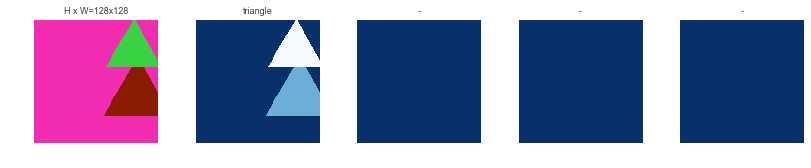

Image id:  8
Image meta [  8 128 128   3   0   0 128 128   1   1   1   1]
Classes (1: circle, 2: square, 3: triangle ):  [2 3 2 1]


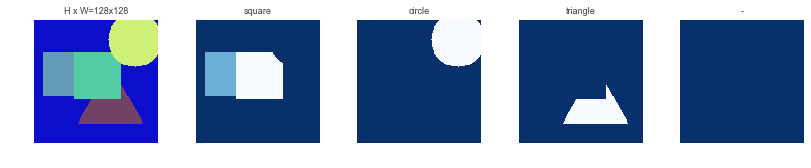

Image id:  99
Image meta [ 99 128 128   3   0   0 128 128   1   1   1   1]
Classes (1: circle, 2: square, 3: triangle ):  [3 1]


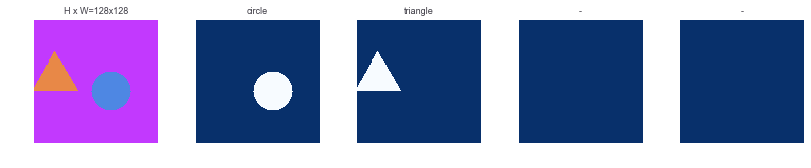

In [22]:
# train_batch_x, train_batch_y = next(train_generator)
imgmeta_idx = model.keras_model.input_names.index('input_image_meta')
img_meta    = train_batch_x[imgmeta_idx]

for img_idx in range(config.BATCH_SIZE):
    image_id = img_meta[img_idx,0]
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print('Image id: ',image_id)
    print('Image meta', img_meta[img_idx])
    print('Classes (1: circle, 2: square, 3: triangle ): ',class_ids)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [23]:

model_output = get_layer_output_2(model.keras_model, train_batch_x, 1)


/* Inputs */
Input  0:  (input_image:0                           ) 	  Input shape: (3, 128, 128, 3)
Input  1:  (input_image_meta:0                      ) 	  Input shape: (3, 12)
Input  2:  (input_rpn_match:0                       ) 	  Input shape: (3, 4092, 1)
Input  3:  (input_rpn_bbox:0                        ) 	  Input shape: (3, 256, 4)
Input  4:  (input_gt_class_ids:0                    ) 	  Input shape: (3, 100)
Input  5:  (input_gt_boxes:0                        ) 	  Input shape: (3, 100, 4)
Input  6:  (input_gt_masks:0                        ) 	  Input shape: (3, 56, 56, 100)
<class 'list'>

/* Outputs */
Output  0: (rpn_class_logits/concat:0               ) 	  Output shape: (3, 4092, 2)
Output  1: (rpn_class/concat:0                      ) 	  Output shape: (3, 4092, 2)
Output  2: (rpn_bbox/concat:0                       ) 	  Output shape: (3, 4092, 4)
Output  3: (rpn_proposal_rois/packed_2:0            ) 	  Output shape: (3, 2000, 4)
Output  4: (proposal_targets/output_rois:0 

In [ ]:
input_image_meta =  train_batch_x[1]
input_rpn_match  =  train_batch_x[2]
input_rpn_bbox   =  train_batch_x[3]
input_gt_class_ids = train_batch_x[4]
input_gt_bboxes = train_batch_x[5]
# gt_masks   =  train_batch_x[6]
print(' input_rpn_match    ', input_rpn_match.shape)
print(' input_rpn_bbox     ', input_rpn_bbox.shape)
print(' input_gt_class_ids ', input_gt_class_ids.shape)
print(' input_gt_bboxes    ', input_gt_bboxes.shape)


In [ ]:
print(len(model_output))
# rpn_class_logits   = model_output[0]
# rpn_class          = model_output[1]
# rpn_bbox           = model_output[2]
# rpn_proposal_rois  = model_output[3]
# output_rois        = model_output[4]
# target_class_ids   = model_output[5]
# target_bbox_deltas = model_output[6]
# roi_gt_boxes       = model_output[7]
# mrcnn_class_logits = model_output[8]
# mrcnn_class        = model_output[9]
# mrcnn_bbox         = model_output[10]
# rpn_class_loss   = model_output[11]
# rpn_bbox_loss    = model_output[12]
# mrcnn_class_loss = model_output[13]
# mrcnn_bbox_loss  = model_output[14]
# fcn_bbox_loss      = model_output[15]
# pred_hm            = model_output[16]
# gt_hm              = model_output[17]
# pred_hm_norm       = model_output[18]
gt_hm_norm         = model_output[19]
# pred_tensor        = model_output[20]
# gt_tensor          = model_output[21]
# gt_deltas          = model_output[22]
fcn_heatmap        = model_output[23]
# fcn_class_logits   = model_output[24]
# fcn_scores         = model_output[25]
# fcn_bbox_deltas    = model_output[26]
# print(type(model_output[4]))
# print(type(output_rois))

In [ ]:
print(pred_tensor[0,2])
print(output_rois[0,:])
width  = pred_tensor[:,:,:,3] - pred_tensor[:,:,:,1]      # x2 - x1
height = pred_tensor[:,:,:,2] - pred_tensor[:,:,:,0]
cx     = pred_tensor[:,:,:,1] + ( width  / 2.0)
cy     = pred_tensor[:,:,:,0] + ( height / 2.0)
means  = np.floor(np.stack((cy,cx),axis = -1))

print(means.shape)
print(means[0,2,:12])

In [ ]:
print(gt_tensor[0,2])
print(output_rois[0,:])
width  = gt_tensor[:,:,:,3] - gt_tensor[:,:,:,1]      # x2 - x1
height = gt_tensor[:,:,:,2] - gt_tensor[:,:,:,0]
cx     = gt_tensor[:,:,:,1] + ( width  / 2.0)
cy     = gt_tensor[:,:,:,0] + ( height / 2.0)
gt_means  = np.floor(np.stack((cy,cx),axis = -1))

print(gt_means.shape)
print(gt_means[0,2,:12])

###  Find maximum of gaussian distributions for the pred_heatmap
Potentially use this as our heatmap scores 
Found out that using MAX values from the class heatmap (currently generated from the pred_tensor that itself is generated form output_rois and mrcnn_class) is not a viable option, because mutlple max values tend to congreagate around the peak of the gaussian distribution. 
This is also the case for gt_heatmaps.
This will probably also be the case for the FCN output.

#### pred_heatmap

In [ ]:
np.set_printoptions(linewidth=150, threshold=10000)

print(pred_hm.shape)
cls_hm = pred_hm[0,:,:,2]
print(cls_hm.shape)
print(np.unravel_index(np.argmax(cls_hm) , cls_hm.shape) )
print(np.max(cls_hm))

print(pred_hm_norm.shape)
cls_hm_norm = pred_hm_norm[0,:,:,2]
print(cls_hm_norm.shape)
print(np.unravel_index(np.argmax(cls_hm_norm) , cls_hm_norm.shape) )
print(np.max(cls_hm_norm))


In [ ]:
hm_ls =np.ravel(cls_hm)
hm_ls_norm = np.ravel(cls_hm_norm)
srtlst = np.argsort(hm_ls)
srtlst_norm = np.argsort(hm_ls_norm)
print(' Sortlist')
print(srtlst[::-1])
print(srtlst.shape)
print('---- norm ------')
print(srtlst_norm[::-1])
print(srtlst_norm.shape)

print(' Top scores')
top_scores = srtlst[:-21:-1]
print('---- norm ------')
top_scores_norm = srtlst_norm[:-21:-1]
print(len(top_scores),top_scores)
print(' Top items ')
for i in top_scores :
    print( i , '  ', np.unravel_index(i, cls_hm.shape))
print('---- norm ------')    
for i in top_scores_norm :
    print( i , '  ', np.unravel_index(i, cls_hm_norm.shape))
print(' Top scores ')
print(hm_ls[top_scores])
print('---- norm ------')    
print(hm_ls_norm[top_scores_norm])


#### gt_heatmap

In [ ]:
np.set_printoptions(linewidth=150, threshold=10000)
print(pred_hm.shape)
cls_hm = gt_hm[0,:,:,2]
print(cls_hm.shape)
print(np.unravel_index(np.argmax(cls_hm) , cls_hm.shape) )
print(np.max(cls_hm))

print('---- norm -----')
print(gt_hm_norm.shape)
cls_hm_norm = gt_hm_norm[0,:,:,2]
print(cls_hm_norm.shape)
print(np.unravel_index(np.argmax(cls_hm_norm) , cls_hm_norm.shape) )
print(np.max(cls_hm_norm))



In [ ]:
hm_ls =np.ravel(cls_hm)
hm_ls_norm = np.ravel(cls_hm_norm)
srtlst = np.argsort(hm_ls)
srtlst_norm = np.argsort(hm_ls_norm)
print(' Sortlist')
print(srtlst[::-1])
print(srtlst.shape)
print('---- norm ------')
print(srtlst_norm[::-1])
print(srtlst_norm.shape)

print(' Top scores')
top_scores = srtlst[:-21:-1]
print('---- norm ------')
top_scores_norm = srtlst_norm[:-21:-1]
print(len(top_scores),top_scores)
print(' Top items ')
for i in top_scores :
    print( i , '  ', np.unravel_index(i, cls_hm.shape))
print('---- norm ------')    
for i in top_scores_norm :
    print( i , '  ', np.unravel_index(i, cls_hm_norm.shape))
print(' Top scores ')
print(hm_ls[top_scores])
print('---- norm ------')    
print(hm_ls_norm[top_scores_norm])


In [ ]:
max_a = np.max(cls_pred_heatmap)
print(max_a.shape)

print(np.unravel_index(np.argmax(prob_a) , prob_a.shape) )

print()

print(' covar ', covar_sqrd)
print(prob_b[35:50, 45:54])
max_b = np.max(prob_b)
print(np.unravel_index(np.argmax(prob_b) , prob_b.shape) )

print('max a , max_b ', max_a, max_b, max_a/max_b)

##  `development build_gaussian_tf ()` 

### Generate Multivariate Normal Distribution from Pred_Tensor

`pred_tensor[:,:,:,1:7]`  == `[116.9736  21.8213  36.2715  45.6026   0.    0.9139   ]`


Detections returned by `detect()` routine:

`[[ 25.          18.          80.          72.           2.           0.99936014]
  [ 51.           3.         106.          71.           3.           0.99924326]`

### Prepare values to pass to build_gaussian_tf

In [ ]:
# mrcnn_bbox  = model_output[11]
# mrcnn_class = model_output[10]
# pred_tensor = model_output[20]
# output_rois = model_output[4]
pred_heatmap= model_output[18]
gt_heatmap  = model_output[19]
print(type(model_output[4]))
print(type(output_rois))

# sess = KB.get_session()
# KB.set_session(sess)
print(len(model_output))
# KB.set_session(sess)
print(type(model_output[4]))
print(type(output_rois))

In [ ]:
img = 1
max_score = np.max(mrcnn_class, axis = -1)
max_class = np.argmax(mrcnn_class, axis = -1)
print(' output_rois[',img,'] \n', output_rois[1]*[128,128,128,128])
print('max class shape:',max_class.shape, 'max score shape: ',max_score.shape)
print('max class[',img,']\n',max_class[img])
print('max score[',img,']\n',max_score[img])
print(' mrcnn class.shape ',mrcnn_class.shape)
print('marcnn_classe[',img,',:]\n',mrcnn_class[1,:])
# print(output_rois[1])
 


###  Display for visual check - `pred_tensor` is the final result which is passed on to  `build_gaussian_tf()`

In [ ]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=6)
# print('scatter shape is ', pred_scatt.get_shape())
print('pred_tensor shape is ', pred_tensor.shape)
img = 0
print('Image ', img , '/ Class 0 ------------')
print(pred_tensor[img,0])
print('Image ', img , '/ Class 1 ------------')
print(pred_tensor[img,1])
print('Image ', img , '/ Class 2 ------------')
print(pred_tensor[img,2])
print('Image ', img , '/ Class 3 ------------')
print(pred_tensor[img,3])

# cls = 3
# print('Image 0 / Class ', cls ,' ------------')
# print(pred_tensor[0, cls].eval())
# print('Image 1 / Class ', cls ,' ------------')
# print(pred_tensor[1, cls].eval())
# print('Image 2 / Class ', cls ,' ------------')
# print(pred_tensor[2, cls].eval())



# print(pred_tensor_out.shape)
# print(pred_tensor_out[2,2, :].eval())
# print(pred_tensor.shape)
# pred_tensor_tst = pred_tensor *[128, 128, 128,128,1,1]
# print(pred_tensor_tst[2,2,:].eval())


####  Display for visual check - `gt_tensor` is the final result which is passed on to  `build_gaussian_tf()`

In [ ]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=6)
# print('scatter shape is ', pred_scatt.get_shape())
print('pred_tensor shape is ', gt_tensor.shape)
img = 1
print('Image ', img , '/ Class 0 ------------')
print(gt_tensor[img,0])
print('Image ', img , '/ Class 1 ------------')
print(gt_tensor[img,1])
print('Image ', img , '/ Class 2 ------------')
print(gt_tensor[img,2])
print('Image ', img , '/ Class 3 ------------')
print(gt_tensor[img,3])


### Copy of `build_gaussian_tf()`

In [ ]:
def build_gaussian_tf(in_tensor, config, names = None):

    num_detections  = config.DETECTION_MAX_INSTANCES
    img_h, img_w    = config.IMAGE_SHAPE[:2]
    batch_size      = config.BATCH_SIZE
    num_classes     = config.NUM_CLASSES  
    print('\n ')
    print('  > BUILD_GAUSSIAN_TF() for ', names )
    
    # rois per image is determined by size of input tensor 
    #   detection mode:   config.TRAIN_ROIS_PER_IMAGE 
    #   ground_truth  :   config.DETECTION_MAX_INSTANCES
    
    print('    orignal in_tensor shape : ', in_tensor.shape)   
    # in_tensor = in_tensor[:,:,:,2:7]
    print('    modified in_tensor shape : ', in_tensor.get_shape())
    
    rois_per_image  = tf.to_int32(in_tensor.shape[2])
    # strt_cls        = 0 if rois_per_image == 32 else 1
    print('    num of bboxes per class is : ', rois_per_image)

    #-----------------------------------------------------------------------------
    ## Build mesh-grid to hold pixel coordinates  
    #-----------------------------------------------------------------------------
    X = tf.range(img_w, dtype=tf.int32)
    Y = tf.range(img_h, dtype=tf.int32)
    X, Y = tf.meshgrid(X, Y)
    # print('    X/Y shapes :',  X.get_shape(), Y.get_shape())
    # print('    X : \n',X.eval())
    # print('    Y : \n',Y.eval())

    # repeat X and Y  batch_size x rois_per_image times
    ones = tf.ones([batch_size, rois_per_image,1, 1], dtype = tf.int32)
    rep_X = ones * X
    rep_Y = ones * Y 
    # print('    Ones: ',ones.shape)                
    # print(' ones_exp * X', ones.shape, '*', X.shape, '= ',rep_X.shape)
    # print(' ones_exp * Y', ones.shape, '*', Y.shape, '= ',rep_Y.shape)

    # # stack the X and Y grids 
    bef_pos = tf.to_float(tf.stack([rep_X,rep_Y], axis = -1))
    # print(' before transpse ', bef_pos.get_shape())
    pos_grid = tf.transpose(bef_pos,[2,3,0,1,4])
    print('    after transpose ', pos_grid.get_shape())    

    # pt2_reshape = tf.reshape( in_tensor , [batch_size, num_classes * rois_per_image ,8])
    # print('    pt2_reshape shape is : ', pt2_reshape.get_shape())
    # print(pt2_reshape[0].eval())
    # print(pt2_reshape[1].eval())
    # print(pt2_reshape[2].eval())

    #-----------------------------------------------------------------------------    
    ## Stack non_zero bboxes from in_tensor into pt2_dense 
    #-----------------------------------------------------------------------------
    pt2_sum = tf.reduce_sum(tf.abs(in_tensor[:,:,:,:-2]), axis=-1)
    print('    pt2_sum shape ',pt2_sum.shape)
    # print(pt2_sum[0].eval())

    pt2_mask = tf.greater(pt2_sum , 0)
    # print(' pt2_mask shape ', pt2_mask.get_shape())
    # print(pt2_mask.eval())

    # pt2_ind shape is [?, 3]. 
    #   pt2_ind[0] corresponds to image_index 
    #   pt2_ind[1] corresponds to class_index 
    #   pt2_ind[2] corresponds to roi row_index 
    pt2_ind  = tf.where(pt2_mask)
    # print('    pt2_ind shape ', pt2_ind.get_shape())
    # print(pt2_ind.eval())
    # pt2_ind_float  =  tf.to_float(pt2_ind[:,0:1])

    # pt2_dense shape is [?, 6]
    #    pt2_dense[0] is image index
    #    pt2_dense[1:4]  roi cooridnaytes 
    #    pt2_dense[5]    is class id 
    pt2_dense = tf.gather_nd( in_tensor, pt2_ind)

    # append image index to front of rows - REMOVED 1-5-2018
    #  pt2_dense = tf.concat([tf.to_float(pt2_ind[:,0:1]), pt2_dense],axis=1)
    print('    dense shape ',pt2_dense.get_shape())
    # print(dense.eval())

    ## split pt2_dense by pt2_ind[:,0], which identifies the image 
    stacked_list = tf.dynamic_partition(pt2_dense, tf.to_int32(pt2_ind[:,0]), num_partitions = batch_size )

    
    #-----------------------------------------------------------------------------
    ##  Build Stacked output from dynamically partitioned lists 
    #-----------------------------------------------------------------------------
    print('    Build Stacked output from dynamically partitioned lists --------------')  

    stacked_output=[]
    for img, item  in enumerate(stacked_list) : 
        rois_in_image  = tf.shape(item)[0]
        pad_item =  tf.pad(item,[[0, rois_per_image - rois_in_image ],[0,0]])
        stacked_output.append(pad_item)
    stacked_tensor = tf.stack(stacked_output)

    # print()    
    # print('   -- Stacked output contents --------------')    
    # print('    stacked_output shape : ', len(stacked_output))
    # for img, item  in enumerate(stacked_output) :
        # print('   img ', img, ' stacked_list[img] ', tf.shape(item).eval() ) 
    # print('   stacked_tensor shape : ', tf.shape(stacked_tensor).eval())
    
    #-----------------------------------------------------------------------------
    ##  Build mean and convariance tensors for Multivariate Normal Distribution 
    #-----------------------------------------------------------------------------
    width  = stacked_tensor[:,:,3] - stacked_tensor[:,:,1]      # x2 - x1
    height = stacked_tensor[:,:,2] - stacked_tensor[:,:,0]
    cx     = stacked_tensor[:,:,1] + ( width  / 2.0)
    cy     = stacked_tensor[:,:,0] + ( height / 2.0)
    means  = tf.stack((cx,cy),axis = -1)
    covar  = tf.stack((width * 0.5 , height * 0.5), axis = -1)
    covar  = tf.sqrt(covar)

    tfd = tf.contrib.distributions
    mvn = tfd.MultivariateNormalDiag( loc  = means,  scale_diag = covar)
    prob_grid = mvn.prob(pos_grid)
    prob_grid = tf.transpose(prob_grid,[2,3,0,1])

    # print('    means shape :', means.get_shape(),' covar shape ', covar.get_shape())
    # print('    from MVN    : mns shape      : ', means.shape, means.get_shape())
    # print('    from MVN    : cov shape      : ', covar.shape, covar.get_shape())
    # print('    from MVN    : mean shape     : ', mvn.mean().get_shape(), '\t stddev shape', mvn.stddev().get_shape())
    # print('    from MVN    : mvn.batch_shape: ', mvn.batch_shape , '\t mvn.event_shape ',  mvn.event_shape)
    # print('    from Linear : op shape       : ', mvn.scale.shape, ' Linear Op batch shape ',mvn.scale.batch_shape)
    # print('    from Linear : op Range Dim   : ', mvn.scale.range_dimension)
    # print('    from Linear : op Domain Dim  : ', mvn.scale.domain_dimension) 
    print('    >> input to MVN.PROB: pos_grid (meshgrid) shape: ', pos_grid.get_shape())
    print('    << output probabilities shape:' , prob_grid.get_shape())
    # print(prob_grid.eval())
    
    #--------------------------------------------------------------------------------
    # kill distributions of NaN boxes (resulting from bboxes with height/width of zero
    # which cause singular sigma cov matrices
    #--------------------------------------------------------------------------------
    gauss_grid = tf.where(tf.is_nan(prob_grid),  tf.zeros_like(prob_grid), prob_grid)

    
    #--------------------------------------------------------------------------------
    ## scatter out the probability distributions based on class
    #--------------------------------------------------------------------------------
    print('\n    Scatter out the probability distributions based on class --------------')     
    class_inds      = tf.to_int32(stacked_tensor[:,:,-2])   # - should be -2 since class moved to that postion
    batch_grid, roi_grid = tf.meshgrid( tf.range(batch_size, dtype=tf.int32), tf.range(rois_per_image, dtype=tf.int32),
                                        indexing = 'ij' )
    scatter_classes = tf.stack([batch_grid, class_inds, roi_grid ],axis = -1)
    gauss_scatt     = tf.scatter_nd(scatter_classes, gauss_grid, [batch_size, num_classes, rois_per_image, img_w, img_h])

    print('    gaussian_grid      : ', gauss_grid.shape)    
    print('    class shape        : ', class_inds.shape)
    print('    roi_grid shape     : ', roi_grid.get_shape() )
    print('    batch_grid shape   : ', batch_grid.get_shape())
    print('    scatter_classes    : ', scatter_classes.get_shape())
    print('    gaussian scattered : ', gauss_scatt.shape)   
    
    ## sum based on class -----------------------------------------------------------------
    print('\n    Reduce sum based on class ---------------------------------------------')         
    gauss_sum = tf.reduce_sum(gauss_scatt, axis=2, name='pred_gaussian')
    gauss_sum = tf.where(gauss_sum > 1e-6, gauss_sum,tf.zeros_like(gauss_sum))
    gauss_sum = tf.transpose(gauss_sum,[0,2,3,1], name = names[0])
    print('    gaussian sum type/name : ', type(gauss_sum), gauss_sum.name, names[0])
    print('    gaussian_sum shape     : ', gauss_sum.get_shape(), 'Keras tensor ', KB.is_keras_tensor(gauss_sum) )    

    # L2 normalization  -----------------------------------------------------------------
    # print('\n    L2 normalization ------------------------------------------------------')         
    
    # gauss_flatten = KB.reshape(gauss_sum, [tf.shape(gauss_sum)[0], -1, tf.shape(gauss_sum)[-1]] )
    # gauss_norm    = KB.l2_normalize(gauss_flatten, axis = 1)
    # gauss_norm    = KB.reshape(gauss_norm, KB.shape(gauss_sum))
    # print('    Shape of guassian_flattened  : ', KB.int_shape(gauss_flatten), 'Keras tensor ', KB.is_keras_tensor(gauss_flatten) )
    # print('    Shape of L2 normalized tensor: ', KB.int_shape(gauss_norm), 'Keras tensor ', KB.is_keras_tensor(gauss_norm) )
    print('    complete')

    return  gauss_sum    # [gauss_sum, gauss_scatt, means, covar]
    


In [ ]:
gauss_sum2 =  build_gaussian_tf(pred_tensor, model.config, names = 'Kevin')

In [ ]:
def build_mask2(input):
    ''' input is a row of the pred_tensor array (x1,y1, x2,y2)
    '''
    # row = input.eval()
    print(row)
    y_extent = tf.range(row[0], row[2])
    x_extent = tf.range(row[1], row[3])
    print('y_extent', y_extent.eval())
    Y,X   = tf.meshgrid(y_extent, x_extent)
    print(Y.shape, X.shape)
    bbox_mask    = tf.stack([Y,X],axis=2)
    print(' bbox_mask shapoe: ',bbox_mask.shape)

    mask_indices = tf.reshape(bbox_mask,[-1,2])
    print('  size of mask_indices: ', mask_indices.shape)

    mask_size = mask_indices.get_shape()[0]
    mask_updates = tf.ones([mask_size], dtype = tf.int32)
    print('  size of bbox_mask: ', mask_size)
    res = tf.scatter_nd_add(ref2, mask_indices, mask_updates)
    print( ' ref shape: ', res.shape)
    print( ' indices shape: ', mask_indices.shape)
    print( ' updates shape: ', mask_updates.shape)
    return res




### `development_build_gaussian_tf()`

In [ ]:
##def development_build_gaussian_tf(in_tensor, config, names = None):
# in_tensor = KB.constant(pred_tensor)
# graph1 = tf.Graph()
# with graph1.as_default():
in_tensor = tf.placeholder(tf.float32, shape=[3,4,32,6], name = 'in_tensor')
config = model.config
names = ['Dev']



num_detections  = config.DETECTION_MAX_INSTANCES
img_h, img_w    = config.IMAGE_SHAPE[:2]
batch_size      = config.BATCH_SIZE
num_classes     = config.NUM_CLASSES  
print('\n ')
print('  > BUILD_GAUSSIAN_TF() for ', names )

# rois per image is determined by size of input tensor 
#   detection mode:   config.TRAIN_ROIS_PER_IMAGE 
#   ground_truth  :   config.DETECTION_MAX_INSTANCES

print('    orignal in_tensor shape : ', in_tensor.shape)   
# in_tensor = in_tensor[:,:,:,2:7]
print('    modified in_tensor shape : ', in_tensor.get_shape())

rois_per_image  = tf.to_int32(in_tensor.shape[2])
# strt_cls        = 0 if rois_per_image == 32 else 1
print('    num of bboxes per class is : ', rois_per_image)

#-----------------------------------------------------------------------------
## Build mesh-grid to hold pixel coordinates  
#-----------------------------------------------------------------------------
X = tf.range(img_w, dtype=tf.int32)
Y = tf.range(img_h, dtype=tf.int32)
X, Y = tf.meshgrid(X, Y)
# print('    X/Y shapes :',  X.get_shape(), Y.get_shape())
# print('    X : \n',X.eval())
# print('    Y : \n',Y.eval())

# repeat X and Y  batch_size x rois_per_image times
ones = tf.ones([batch_size, rois_per_image,1, 1], dtype = tf.int32)
rep_X = ones * X
rep_Y = ones * Y 
# print('    Ones: ',ones.shape)                
# print(' ones_exp * X', ones.shape, '*', X.shape, '= ',rep_X.shape)
# print(' ones_exp * Y', ones.shape, '*', Y.shape, '= ',rep_Y.shape)

# # stack the X and Y grids 
bef_pos = tf.to_float(tf.stack([rep_X,rep_Y], axis = -1))
# print(' before transpse ', bef_pos.get_shape())
pos_grid = tf.transpose(bef_pos,[2,3,0,1,4])
print('    after transpose ', pos_grid.get_shape())    

# pt2_reshape = tf.reshape( in_tensor , [batch_size, num_classes * rois_per_image ,8])
# print('    pt2_reshape shape is : ', pt2_reshape.get_shape())
# print(pt2_reshape[0].eval())
# print(pt2_reshape[1].eval())
# print(pt2_reshape[2].eval())

#-----------------------------------------------------------------------------    
## Stack non_zero bboxes from in_tensor into pt2_dense 
##  identify rows that have a non_zero bbox (pt2_sum > 0)
##  get the indices  pt2_ind 
#-----------------------------------------------------------------------------
pt2_sum = tf.reduce_sum(tf.abs(in_tensor[:,:,:,:-2]), axis=-1)
print('    pt2_sum shape ',pt2_sum.shape)
# print(pt2_sum[0].eval())

pt2_mask = tf.greater(pt2_sum , 0)
# print(' pt2_mask shape ', pt2_mask.get_shape())
# print(pt2_mask.eval())

# pt2_ind shape is [?, 3]. 
#   pt2_ind[0] corresponds to image_index 
#   pt2_ind[1] corresponds to class_index 
#   pt2_ind[2] corresponds to roi row_index 
pt2_ind  = tf.where(pt2_mask)
print('    pt2_ind shape ', pt2_ind.get_shape())
#     print(pt2_ind.eval())
# pt2_ind_float  =  tf.to_float(pt2_ind[:,0:1])

# pt2_dense shape is [?, 6]
#    pt2_dense[0] is image index
#    pt2_dense[1:4]  roi cooridnaytes 
#    pt2_dense[5]    is class id 
pt2_dense = tf.gather_nd( in_tensor, pt2_ind)

# append image index to front of rows - REMOVED 1-5-2018
#  pt2_dense = tf.concat([tf.to_float(pt2_ind[:,0:1]), pt2_dense],axis=1)
print('    dense shape ',pt2_dense.get_shape())
# print(pt2_dense.eval())

## split pt2_dense by pt2_ind[:,0], which identifies the image 
stacked_list = tf.dynamic_partition(pt2_dense, tf.to_int32(pt2_ind[:,0]), num_partitions = batch_size )


#-----------------------------------------------------------------------------
##  Build Stacked output from dynamically partitioned lists 
#-----------------------------------------------------------------------------
print('    Build Stacked output from dynamically partitioned lists --------------')  

stacked_output=[]
for img, item  in enumerate(stacked_list) : 
    rois_in_image  = tf.shape(item)[0]
    pad_item =  tf.pad(item,[[0, rois_per_image - rois_in_image ],[0,0]])
    stacked_output.append(pad_item)
stacked_tensor = tf.stack(stacked_output)

# print()    
# print('   -- Stacked output contents --------------')    
# print('    stacked_output shape : ', len(stacked_output))
# for img, item  in enumerate(stacked_output) :
    # print('   img ', img, ' stacked_list[img] ', tf.shape(item).eval() ) 
# print('   stacked_tensor shape : ', tf.shape(stacked_tensor).eval())
rnd_tensor = tf.floor(stacked_tensor[:,:,:5])    


#-----------------------------------------------------------------------------
##  Build mean and convariance tensors for Multivariate Normal Distribution 
#-----------------------------------------------------------------------------
width  = stacked_tensor[:,:,3] - stacked_tensor[:,:,1]      # x2 - x1
height = stacked_tensor[:,:,2] - stacked_tensor[:,:,0]
cx     = stacked_tensor[:,:,1] + ( width  / 2.0)
cy     = stacked_tensor[:,:,0] + ( height / 2.0)
means  = tf.stack((cx,cy),axis = -1)
covar  = tf.stack((width * 0.5 , height * 0.5), axis = -1)
covar  = tf.sqrt(covar)

tfd = tf.contrib.distributions
mvn = tfd.MultivariateNormalDiag( loc  = means,  scale_diag = covar)
prob_grid = mvn.prob(pos_grid)
prob_grid = tf.transpose(prob_grid,[2,3,0,1])

# print('    means shape :', means.get_shape(),' covar shape ', covar.get_shape())
# print('    from MVN    : mns shape      : ', means.shape, means.get_shape())
# print('    from MVN    : cov shape      : ', covar.shape, covar.get_shape())
# print('    from MVN    : mean shape     : ', mvn.mean().get_shape(), '\t stddev shape', mvn.stddev().get_shape())
# print('    from MVN    : mvn.batch_shape: ', mvn.batch_shape , '\t mvn.event_shape ',  mvn.event_shape)
# print('    from Linear : op shape       : ', mvn.scale.shape, ' Linear Op batch shape ',mvn.scale.batch_shape)
# print('    from Linear : op Range Dim   : ', mvn.scale.range_dimension)
# print('    from Linear : op Domain Dim  : ', mvn.scale.domain_dimension) 
print('    >> input to MVN.PROB: pos_grid (meshgrid) shape: ', pos_grid.get_shape())
print('    << output probabilities shape:' , prob_grid.get_shape())
# print(prob_grid.eval())

#--------------------------------------------------------------------------------
# kill distributions of NaN boxes (resulting from bboxes with height/width of zero
# which cause singular sigma cov matrices
#--------------------------------------------------------------------------------
gauss_grid = tf.where(tf.is_nan(prob_grid),  tf.zeros_like(prob_grid), prob_grid)


## scatter out the probability distributions based on class ----------------------------
print('\n    Scatter out the probability distributions based on class --------------')     
class_inds      = tf.to_int32(stacked_tensor[:,:,-2])   # - should be -2 since class moved to that postion
batch_grid, roi_grid = tf.meshgrid( tf.range(batch_size, dtype=tf.int32), tf.range(rois_per_image, dtype=tf.int32),
                                    indexing = 'ij' )
scatter_classes = tf.stack([batch_grid, class_inds, roi_grid ],axis = -1)
gauss_scatt     = tf.scatter_nd(scatter_classes, gauss_grid, [batch_size, num_classes, rois_per_image, img_w, img_h])

print('    gaussian_grid      : ', gauss_grid.shape)    
print('    class shape        : ', class_inds.shape)
print('    roi_grid shape     : ', roi_grid.get_shape() )
print('    batch_grid shape   : ', batch_grid.get_shape())
print('    scatter_classes    : ', scatter_classes.get_shape())
print('    gaussian scattered : ', gauss_scatt.shape)   

## sum based on class -----------------------------------------------------------------
print('\n    Reduce sum based on class ---------------------------------------------')         
gauss_sum = tf.reduce_sum(gauss_scatt, axis=2, name='pred_gaussian')
gauss_sum = tf.where(gauss_sum > 1e-6, gauss_sum,tf.zeros_like(gauss_sum))
gauss_sum = tf.transpose(gauss_sum,[0,2,3,1], name = names[0])
print('    gaussian sum type/name : ', type(gauss_sum), gauss_sum.name, names[0])
print('    gaussian_sum shape     : ', gauss_sum.get_shape(), 'Keras tensor ', KB.is_keras_tensor(gauss_sum) )    


print('\n    L2 normalization ------------------------------------------------------')   
heatmap_shape=KB.shape(gauss_sum)
print(' pred_shape: KB.shape:' , heatmap_shape, ' tf.get_shape(): ', heatmap_shape.get_shape(), ' pred_maks.shape:', 
                                 gauss_sum.shape, 'tf.shape :', tf.shape(gauss_sum))

output_flatten = KB.reshape(gauss_sum, (heatmap_shape[0], -1, heatmap_shape[-1]) )
output_norm1   = KB.l2_normalize(output_flatten, axis = 1)    
output_norm    = KB.identity(KB.reshape(output_norm1,  heatmap_shape ) , name = names[0]+'_norm')   

print('   output_flatten    : ', KB.int_shape(output_flatten) , output_flatten.get_shape(),' Keras tensor ', KB.is_keras_tensor(output_flatten) )
print('   output_norm1      : ', KB.int_shape(output_norm1)   ,   output_norm1.get_shape(),' Keras tensor ', KB.is_keras_tensor(output_norm1) )
print('   output_norm final : ', KB.int_shape(output_norm)    ,    output_norm.get_shape(),' Keras tensor ', KB.is_keras_tensor(output_norm) )


## return  gauss_sum    # [gauss_sum, gauss_scatt, means, covar]



###  Tensorflow execution

In [ ]:
feed_dict = {in_tensor: pred_tensor}
fetches = [stacked_tensor, rnd_tensor, gauss_sum]
sess = tf.Session()
print(' tfsession() is ', sess)
tt = sess.run(fetches, feed_dict = feed_dict )
print(type(tt), len(tt))
sess.close()

img = 1
print(' Stacked Tensor Shape: ', tt[0].shape)
print(' Stacked Tensor :   \n ', tt[0][img])

print(' rnd_tensor shape ', tt[1].shape)
print(' rnd_tensor :  \n ', tt[1][img])

print(' Gauss_Sum shape :\n', tt[2].shape)
# print(' FP gt boxes        :\n', tt[3])
# print(' FP gt class assign :\n', tt[4])
# print(' gt class ids assign :\n', tt[5])
# print()
# print('fp_rois ', tt[6].shape, '\n',tt[6])
# print('rois ', tt[9].shape, '\n',tt[9])
# print()
# print('fp_rois_gt_boxes ', tt[7].shape, '\n',tt[7])
# print('rois_gt_boxes ', tt[10].shape, '\n',tt[10])
# print()
# print('fp_rois_gt_class_ids ', tt[8].shape, '\n',tt[8])
# print('rois_gt_class_ids ', tt[11].shape, '\n',tt[11])
# # return positive_ind_shuffled, positive_indices, positive_overlaps, roi_gt_box_assignment,roi_gt_boxes, roi_gt_class_ids

In [ ]:
with sess.as_default():
    gauss_sum = development_build_gaussian_tf(KB.constant(pred_tensor), model.config, names = ['Dev'])

In [ ]:
    rnd_tensor = tf.floor(stacked_tensor)    
    sum_tensor = tf.reduce_sum(tf.abs(rnd_tensor[:,:,:4]), axis=-1)
    non_zero   = tf.cast(sum_tensor, tf.bool)
    non_zero_exp = tf.expand_dims(non_zero, axis =-1)
    
    print(' rnd_tensor :', tf.shape(rnd_tensor).eval())
    print(' sum_tensor :', tf.shape(sum_tensor).eval())
    print(' non_zero   :', tf.shape(non_zero).eval())
    print(' non_zero_exp:', tf.shape(non_zero_exp).eval())
    non_zero_exp = KB.repeat_elements(non_zero_exp, 6, axis=-1)
    print(' non_zero_exp:', tf.shape(non_zero_exp).eval())
    nz_tensor  = tf.boolean_mask(rnd_tensor, non_zero_exp, axis = -1)
    print(' nz_tensor  :', tf.shape(nz_tensor).eval())

#     print(stacked_tensor[0].eval())
    print(rnd_tensor[0].eval())
    print()
#     print(stacked_tensor[1].eval())
    print(rnd_tensor[1].eval())
    print()
#     print(stacked_tensor[2].eval())
    print(rnd_tensor[2].eval())
    
    print(sum_tensor[1].eval())    
    print(non_zero[1].eval())    
#     non_zeros = tf.cast(tf.reduce_sum(tf.abs(rnd_tensor), axis=1), tf.bool)
    print(non_zero_exp[1].eval())    

    print(nz_tensor[1].eval())
    print()


###  Test `means`, `covar`, `gauss_grid`, and `gauss_sum ` between development version and final version

In [ ]:
print(means.get_shape(), means.get_shape())
tst1 = means.eval()
tst2 = means2.eval()
print(tst1.shape, tst2.shape)

print(tst1[0,:10])
print()
print(tst2[0,:10])
print(np.all(tst1 == tst2))
print()
del tst1, tst2

In [ ]:
tst1 = st.eval()
tst2 = st2.eval()
print(tst1.shape, tst2.shape)

print(tst1[0,:10])
print()
print(tst2[0,:10])
print(np.all(tst1 == tst2))
print()
del tst1, tst2

In [ ]:
tst1 = gauss_grid.eval()
tst2 = gauss_grid2.eval()
print(tst1.shape, tst2.shape)

print(tst1[0,0,:10])
print()
print(tst2[0,0,:10])
print(np.all(tst1 == tst2))
# print()
del tst1, tst2

In [ ]:
tst1 = gauss_sum.eval()
tst2 = gauss_sum2.eval()
print(tst1.shape, tst2.shape)

# print(tst1[0,0,:10])
# print()
# print(tst2[0,0,:10])
print(np.all(tst1 == tst2))
# print()
del tst1, tst2

###  Compute mean and max of `gauss_grid()`

In [ ]:
print(gauss_grid.shape)
for img in [0,1,2]:
    for bbx in range(32):
        gauss_mean = KB.mean(gauss_grid[img, bbx,:,:]).eval()
        gauss_min  = KB.min(gauss_grid[img, bbx,:,:]).eval()
        gauss_max  = KB.max(gauss_grid[img, bbx,:,:]).eval()
#         prob    = stacked_tensor[img,bbx,-1].eval() 'prob: ',prob ,
        print('Img/bbx: {}/{}     Mean:  {:6e}  \t Max: {:6e}  \t Min : {:6e}'.format(img, bbx, gauss_mean, gauss_max, gauss_min))

###  Compute mean and max of `gauss_grid2()`

In [ ]:
print(gauss_grid2.shape)
for img in [0,1,2]:
    for bbx in range(32):
        gauss_mean = KB.mean(gauss_grid2[img, bbx,:,:]).eval()
        gauss_min  = KB.min(gauss_grid2[img, bbx,:,:]).eval()
        gauss_max  = KB.max(gauss_grid2[img, bbx,:,:]).eval()
#         prob    = stacked_tensor[img,bbx,-1].eval() 'prob: ',prob ,
        print('Img/bbx: {}/{}     Mean:  {:6e}  \t Max: {:6e}  \t Min : {:6e}'.format(img, bbx, gauss_mean, gauss_max, gauss_min))

###  Compute `gauss_grid()` and   `gauss_grid2()`

In [ ]:
print(gauss_grid2.shape)
gauss_max  = KB.max(gauss_grid, axis = [2,3]).eval()
gauss_max2  = KB.max(gauss_grid2, axis = [2,3]).eval()

for img in [0,1,2]:
    for bbx in range(32):

#         prob    = stacked_tensor[img,bbx,-1].eval() 'prob: ',prob ,
        print('Img/bbx: {}/{}     MAX:  {:6e}  \t MAX2: {:6e}  \t Equal : {}'.format(img, bbx, gauss_max[img, bbx],gauss_max2[img,bbx],(gauss_max[img,bbx]== gauss_max2[img,bbx])))
del gauss_max, gauss_max2    

### Compute `gauss_sum()` and  `gauss_sum2()`

In [ ]:
print(gauss_sum.shape, gauss_sum2.shape)
# print(gauss_grid2.shape)
tst1 = tf.transpose(gauss_sum, [0,3,1,2])
tst2 = tf.transpose(gauss_sum2, [0,3,1,2])
print(tst1.shape, tst2.shape)

gauss_max1 = KB.max(tst1, axis = [2,3]).eval()
gauss_max2 = KB.max(tst2, axis = [2,3]).eval()
print(gauss_max1.shape, gauss_max2.shape)

# gauss_max2  = KB.max(gauss_grid2, axis = [2,3]).eval()

for img in [0,1,2]:
    for bbx in range(4):
        print('Img/bbx: {}/{}     MAX:  {:6e}  \t MAX2: {:6e}  \t Equal : {}'.format(img, bbx, gauss_max1[img, bbx],gauss_max2[img,bbx],(gauss_max1[img,bbx]== gauss_max2[img,bbx])))
   

In [ ]:
for img in [0,1,2]:
    for bbx in range(4):
        print('Img/bbx: {}/{}    Equal : {}'.format(img, bbx, (tst1[img,bbx]==  tst2[img,bbx])))
del gauss_max1, gauss_max2    


###  Compute mean and max OF `gauss_sum2()`

In [ ]:
print(gauss_sum2.shape)
for img in [0,1,2]:
    for cls in range(4):
        gauss_mean = KB.mean(gauss_sum2[img,:,:,cls]).eval()
        gauss_min  = KB.min(gauss_sum2[img, :,:,cls]).eval()
        gauss_max  = KB.max(gauss_sum2[img, :,:,cls]).eval()
        print('Img/bbx: ', img, '/',cls ,'   Mean: ', gauss_mean, '\t Max: ' , gauss_max, '\t Min :', gauss_min)

### Compute min and max of `gauss_sum()`

In [ ]:
print(gauss_sum.shape)
for img in [0,1,2]:
    for cls in range(4):
        gauss_mean = KB.mean(gauss_sum[img,:,:,cls]).eval()
        gauss_min  =  KB.min(gauss_sum[img, :,:,cls]).eval()
        gauss_max  =  KB.max(gauss_sum[img, :,:,cls]).eval()
        print('Img/bbx: ', img, '/',cls ,'   Mean: ', gauss_mean, '\t Max: ' , gauss_max, '\t Min :', gauss_min)

In [ ]:
pred_gauss = tf.constant(layers_out[19])
print(pred_gauss.shape)
for img in [0,1,2]:
    for cls in range(4):
        gauss_mean = KB.mean(pred_gauss[img,:,:,cls]).eval()
        gauss_min  = KB.min(pred_gauss[img, :,:,cls]).eval()
        gauss_max  = KB.max(pred_gauss[img, :,:,cls]).eval()
        print('Img/bbx: ', img, '/',cls ,'   Mean: ', gauss_mean, '\t Max: ' , gauss_max, '\t Min :', gauss_min)

### Plot Predicted  Heatmaps `pred_gaussian` 

`pred_gaussian2` and `gt_gaussian2` from Tensorflow PCN layer

In [ ]:
%matplotlib notebook
# gt_heatmap  = layers_out[27]     # gt_gaussiam 
# pred_heatmap= layers_out[24]  # pred_gaussian
# gt_heatmap  = gauss_sum.eval()    # gt_gaussiam 
gt_heatmap  = layers_out[18]     # gt_gaussiam 

pred_heatmap= gauss_sum2.eval()  # pred_gaussian
print('gt_gaussian heatmap shape : ', gt_heatmap.shape, ' pred_gaussian heatmap shape: ', pred_heatmap.shape)
num_images = 1 # config.IMAGES_PER_GPU
num_classes = config.NUM_CLASSES

img = 0

image_id = img_meta[img,0]
print('Image id: ',image_id)
print('Classes (1: circle, 2: square, 3: triangle ): ')
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


for cls in range(1,num_classes):
    ttl = 'GROUND TRUTH HEATMAP - image :  {} class: {} '.format(img,cls)
    print(' *** Zout  ', gt_heatmap[img,:,:,cls].shape, ttl)   
    plot_gaussian( gt_heatmap[img,:,:,cls], title = ttl)
    
    ttl = 'PREDICTED heatmap  - image :  {} class: {} '.format(img,cls)     
    print(' *** pred_heatmap ', pred_heatmap[img,:,:,cls].shape, ttl)   
    plot_gaussian(pred_heatmap[img,:,:,cls], title = ttl)  

### Plot Predicted  Heatmaps `pred_gaussian` 

`pred_gaussian2` and `gt_gaussian2` from Tensorflow PCN layer

In [ ]:
%matplotlib notebook
# gt_heatmap  = layers_out[27]     # gt_gaussiam 
# pred_heatmap= layers_out[24]  # pred_gaussian
gt_heatmap  = layers_out[19]     # gt_gaussiam 
pred_heatmap= layers_out[18]  # pred_gaussian
print('gt_gaussian heatmap shape : ', gt_heatmap.shape, ' pred_gaussian heatmap shape: ', pred_heatmap.shape)
num_images = 1 # config.IMAGES_PER_GPU
num_classes = config.NUM_CLASSES

img = 0

image_id = img_meta[img,0]
print('Image id: ',image_id)
print('Classes (1: circle, 2: square, 3: triangle ): ')
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


for cls in range(1,num_classes):
    ttl = 'GROUND TRUTH HEATMAP - image :  {} class: {} '.format(img,cls)
    print(' *** Zout  ', gt_heatmap[img,:,:,cls].shape, ttl)   
    plot_gaussian( gt_heatmap[img,:,:,cls], title = ttl)
    
    ttl = 'PREDICTED heatmap  - image :  {} class: {} '.format(img,cls)     
    print(' *** pred_heatmap ', pred_heatmap[img,:,:,cls].shape, ttl)   
    plot_gaussian(pred_heatmap[img,:,:,cls], title = ttl)  


### Plot Predicted and Ground Truth Probability Heatmaps `pred_gaussian` and `gt_gaussian` (Tensorflow)

`pred_gaussian2` and `gt_gaussian2` from Tensorflow PCN layer

In [ ]:
%matplotlib notebook
# gt_heatmap  = layers_out[27]     # gt_gaussiam 
# pred_heatmap= layers_out[24]  # pred_gaussian
gt_heatmap  = layers_out[19]     # gt_gaussiam 
pred_heatmap= layers_out[18]  # pred_gaussian
print('gt_gaussian heatmap shape : ', gt_heatmap.shape, ' pred_gaussian heatmap shape: ', pred_heatmap.shape)
num_images = 1 # config.IMAGES_PER_GPU
num_classes = config.NUM_CLASSES

img = 0

image_id = img_meta[img,0]
print('Image id: ',image_id)
print('Classes (1: circle, 2: square, 3: triangle ): ')
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


for cls in range(1,num_classes):
    ttl = 'GROUND TRUTH HEATMAP - image :  {} class: {} '.format(img,cls)
    print(' *** Zout  ', gt_heatmap[img,:,:,cls].shape, ttl)   
    plot_gaussian( gt_heatmap[img,:,:,cls], title = ttl)
    
    ttl = 'PREDICTED heatmap  - image :  {} class: {} '.format(img,cls)     
    print(' *** pred_heatmap ', pred_heatmap[img,:,:,cls].shape, ttl)   
    plot_gaussian(pred_heatmap[img,:,:,cls], title = ttl)  

###  Softmax Sparse Cross Entropy Ignoring Last Label -- Used in Keras FCN

In [ ]:
import keras.backend as K 

y_pred = tf.placeholder(dtype=tf.float32, shape=(16,320,320,20))
y_true = tf.placeholder(dtype=tf.float32, shape=(16,320,320,1))
print(K.int_shape(y_pred), K.int_shape(y_true))
y_pred = K.reshape(y_pred, (-1, K.int_shape(y_pred)[-1]))
print(K.int_shape(y_pred))
log_softmax = tf.nn.log_softmax(y_pred)
print(K.int_shape(log_softmax))

y_true = K.flatten(y_true)
print(K.int_shape(y_true))

y_true = K.one_hot(tf.to_int32(y_true), K.int_shape(y_pred)[-1]+1)
print(K.int_shape(y_true))

unpacked = tf.unstack(y_true, axis=-1)
print(len(unpacked), unpacked[0].shape)

y_true = tf.stack(unpacked[:-1], axis=-1)
print(K.int_shape(y_true))


cross_entropy = -K.sum(y_true * log_softmax, axis=1)
print(K.int_shape(cross_entropy))

cross_entropy_mean = K.mean(cross_entropy)
print(K.int_shape(cross_entropy_mean))




# import keras.backend as K
# print(K.int_shape(bef_pos)[-1])
# unpacked  = K.flatten(test)
# unpacked.shape

### Experimental code to Create mask for class bounding boxes


###  `build_mask` routine 

In [ ]:
    print(tt[1][1])

In [ ]:
def dev_build_mask2(input):
    # row = input.eval()
    print(row)
    y_extent = tf.range(row[0], row[2])
    x_extent = tf.range(row[1], row[3])
    print('y_extent', y_extent.eval())
    Y,X   = tf.meshgrid(y_extent, x_extent)
    print(Y.shape, X.shape)
    bbox_mask    = tf.stack([Y,X],axis=2)
    print(' bbox_mask shapoe: ',bbox_mask.shape)

    mask_indices = tf.reshape(bbox_mask,[-1,2])
    print('  size of mask_indices: ', mask_indices.shape)

    mask_size = mask_indices.get_shape()[0]
    mask_updates = tf.ones([mask_size], dtype = tf.int32)
    print('  size of bbox_mask: ', mask_size)
    res = tf.scatter_nd_add(ref2, mask_indices, mask_updates)
    print( ' ref shape: ', res.shape)
    print( ' indices shape: ', mask_indices.shape)
    print( ' updates shape: ', mask_updates.shape)
    return res

###  Comparing Scipy / Tensorflow Multivar normal distribution 

In [ ]:
tfd        = tf.contrib.distributions
grid       = pos_grid_1[:,:,0,0,:]
covar      = np.array([27.7818, 26.6678],dtype = np.float32)
covar_sqrt = np.sqrt(covar)
covar_sqrd = covar ** 2
full_covar = np.array([[27.7818, 0],[0, 26.6678]],dtype = np.float32)
mean       = np.array([48.8926, 36.101 ],dtype = np.float32)

print('   grid :', grid.dtype, grid.shape)
print('   Covar sqrt :', covar_sqrt)
print('   Covar sqrd :', covar_sqrd)

mvn1  = tfd.MultivariateNormalDiag(loc=mean,scale_diag=covar_sqrt)
prob1 = mvn1.prob(grid2)
print()
print('   mvn1 mean             ', mvn1.mean().eval())
print('   mvn1 std deviation    ', mvn1.stddev().eval())
print('   mvn1 covariance:      ', '\n', mvn1.covariance().eval())
print('   mvn1 location         ', mvn1.loc.eval())
print('   Linear OP shape       ', mvn1.scale.shape)
print('   Linear Op batch shape ', mvn1.scale.batch_shape)
print('   Linear op Range Dim   ', mvn1.scale.range_dimension)
print('   Linear op Domain Dim  ', mvn1.scale.domain_dimension) 
print('   Linear op Domain Dim  ', mvn1.scale.diag_part().eval()) 

mvn2  = tfd.MultivariateNormalDiag(loc=mean,scale_diag=covar)
prob2 = mvn2.prob(grid2)
print()
print('   mvn2 mean             ', mvn2.mean().eval())
print('   mvn2 std deviation    ', mvn2.stddev().eval())
print('   mvn2 covariance:      ', '\n', mvn2.covariance().eval())
print('   mvn2 location         ', mvn2.loc.eval())
print('   Linear OP shape       ', mvn2.scale.shape)
print('   Linear Op batch shape ', mvn2.scale.batch_shape)
print('   Linear op Range Dim   ', mvn2.scale.range_dimension)
print('   Linear op Domain Dim  ', mvn2.scale.domain_dimension) 
print('   Linear op Domain Dim  ', mvn2.scale.diag_part().eval()) 


mvn3  = tfd.MultivariateNormalFullCovariance( loc = mean, covariance_matrix = full_covar)
prob3 = mvn3.prob(grid2)
print()
print('   mvn3 mean             ', mvn3.mean().eval())
print('   mvn3 std deviation    ', mvn3.stddev().eval())
print('   mvn3 covariance:      ', '\n', mvn3.covariance().eval())
print('   mvn3 location         ', mvn3.loc.eval())
print('   Linear OP shape       ', mvn3.scale.shape)
print('   Linear Op batch shape ', mvn3.scale.batch_shape)
print('   Linear op Range Dim   ', mvn3.scale.range_dimension)
print('   Linear op Domain Dim  ', mvn3.scale.domain_dimension) 
print('   Linear op Domain Dim  ', mvn3.scale.diag_part().eval()) 

print('   << output probabilities shape:' )
print(' prob1 ', prob1.get_shape())
print(prob1.eval())
print(' prob2 ', prob2.get_shape())
print(prob2.eval())
print(' prob3 ', prob3.get_shape())
print(prob3.eval())

In [ ]:
np.set_printoptions(linewidth=150, threshold=10000)
from scipy.stats import  multivariate_normal
# Build mesh-grid to hold pixel coordinates ----------------------------------
XX = np.arange(0, img_w, 1)
YY = np.arange(0, img_h, 1)
XX, YY = np.meshgrid(XX, YY)
pos  = np.empty(XX.shape + (2,))   # concatinate shape of x to make ( x.rows, x.cols, 2)
pos[:,:,0] = XX;
pos[:,:,1] = YY;
# print(XX)
# print(YY)
# print(pos[0,:,:])
# print(pos[0])
# print(grid[0].eval())
print(' pos type    ', type(pos), type(grid))
print(' grid shape ', pos.shape, grid.shape)
print(np.all(pos == grid.eval()))
print(' mean  ', mean)
print(' covar ', covar)
mvna    = multivariate_normal(mean, covar)
prob_a = mvna.pdf(pos)

mvnb = multivariate_normal(mean, covar_sqrd)
prob_b = mvnb.pdf(pos)

print(prob_a[35:50, 45:54])
max_a = np.max(prob_a)
print(np.unravel_index(np.argmax(prob_a) , prob_a.shape) )

print()

print(' covar ', covar_sqrd)
print(prob_b[35:50, 45:54])
max_b = np.max(prob_b)
print(np.unravel_index(np.argmax(prob_b) , prob_b.shape) )

print('max a , max_b ', max_a, max_b, max_a/max_b)

###  Build indicies to gather bounding boxes from bboxes_4d corrsponding to predicted class
#### Only used if we want to use mrcnn_bboxes (batch_size, num_rois, num_classes, 4)

batch_size x nuum_detections x 4

In [ ]:
###  Build indicies to gather bounding boxes from bboxes_4d corrsponding to predicted class
###  Only used if we want to use mrcnn_bboxes (batch_size, num_rois, num_classes, 4)

# gather_boxes = tf.stack([batch_grid, roi_grid, pred_classes, ], axis = -1)

# print('-- gather_boxes  ----')
# print('gather_boxes inds', type(gather_boxes), 'shape',tf.shape(gather_boxes).eval())
# print(gather_boxes.eval())

# mrcnn_bboxes_selected = tf.gather_nd(mrcnn_bboxes, gather_boxes)
# print(' padding required for output_rois : ', mrcnn_bboxes_selected.get_shape())
# print(mrcnn_bboxes_selected[0].eval())

# print(' output_rois shape ', output_rois.get_shape())
# print(pred_classes[0].eval())
# print(output_rois[0].eval())



## Experimental Code

###  Experiment for sort ordering 

In [ ]:
indices = tf.constant([
            [[0,2],[0,1],[0,0]],
            [[1,2],[1,1],[1,0]],
            [[2,0],[2,1],[2,1]],
          ])
params = tf.constant( [
          [['0-00', '0-01', '0-02', '0-03'], 
           ['0-10', '0-11', '0-12', '0-13'],
           ['0-20', '0-21', '0-22', '0-23'],
           ['0-30', '0-31', '0-32', '0-33']],
    
          [['1-00', '1-01', '1-02', '1-03'], 
           ['1-10', '1-11', '1-12', '1-13'],
           ['1-20', '1-21', '1-22', '1-23'],
           ['1-30', '1-31', '1-32', '1-33']],
    
          [['2-00', '2-01', '2-02', '2-03'], 
           ['2-10', '2-11', '2-12', '2-13'],
           ['2-20', '2-21', '2-22', '2-23'],
           ['2-30', '2-31', '2-32', '2-33']]    
         ])
print(params.shape, '   ', indices.shape)
res = tf.gather_nd(params, indices)
res.eval()



###  Experiment with GATHER() for splitting into classes

In [ ]:
# indices = tf.constant([
#             [0,2,2],[0,1,1],[0,0,0],
#             [1,2,2],[1,1,1],[1,0,0],
#             [2,0,0],[2,1,1],[2,1,1],
#            ])
# indices = tf.constant([ [0,2],[0,1],[0,0],[1,2],[1,1],[1,0],[1,2],[1,3], [2,3]] ) # 9 x 2
indices = tf.constant([
           [
            [[0,2],[0,1],[0,0],[1,2],[2,3]],
            [[1,1],[1,0],[1,2],[1,3],[1,1]]
           ]
           ])
params = tf.constant( [
          [['0-00', '0-01', '0-02', '0-03', '0-04', '0-05', '0-06'], 
           ['0-10', '0-11', '0-12', '0-13', '0-14', '0-15', '0-16'],
           ['0-20', '0-21', '0-22', '0-23', '0-24', '0-25', '0-26'],
           ['0-30', '0-31', '0-32', '0-33', '0-34', '0-35', '0-36'],
           ['0-40', '0-41', '0-42', '0-43', '0-44', '0-45', '0-46']],
                                                          
          [['1-00', '1-01', '1-02', '1-03', '1-04', '1-05', '1-06'], 
           ['1-10', '1-11', '1-12', '1-13', '1-14', '1-15', '1-16'],
           ['1-20', '1-21', '1-22', '1-23', '1-24', '1-25', '1-26'],
           ['1-30', '1-31', '1-32', '1-33', '1-34', '1-35', '1-36'],
           ['1-40', '1-41', '1-42', '1-43', '1-44', '1-45', '1-46']],
                                                          
          [['2-00', '2-01', '2-02', '2-03', '2-04', '2-05', '2-06'], 
           ['2-10', '2-11', '2-12', '2-13', '2-14', '2-15', '2-16'],
           ['2-20', '2-21', '2-22', '2-23', '2-24', '2-25', '2-26'],
           ['2-30', '2-31', '2-32', '2-33', '2-34', '2-35', '2-36'],
           ['2-40', '2-41', '2-42', '2-43', '2-44', '2-45', '2-46']]    
         ])
print(' params sahape: ', params.shape, ' parms[:axis]', params.shape[:0], params.shape[:1], params.shape[:2], params.shape[:3])
print(' params sahape: ', params.shape, ' parms[:axis]', params.shape[0:], params.shape[1:], params.shape[2:], params.shape[3:])
print(' indices.shape  ', indices.shape)
res = tf.gather_nd(params, indices)
print('result shape   ', res.get_shape())
res.eval()

In [ ]:
num_detections = 8
# batch_size is  3
gt_class_ids = tf.constant([[1,2,3,0,0,0,0,0],[3,3,3,0,0,0,0,0],[1,2,2,0,0,2,0,0]])
gt_bboxes    = tf.random_uniform([batch_size,3,4], maxval = 127, dtype=tf.int32)


gt_classes_exp = tf.to_float(tf.expand_dims(gt_class_ids ,axis=-1))
print('    gt_classes_exp: ' ,gt_classes_exp.get_shape())
print(gt_classes_exp.eval())


zeros        = tf.zeros([batch_size,5,4], dtype = tf.int32)
gt_bboxes    = tf.concat([gt_bboxes, zeros], axis = 1)
gt_bboxes    = tf.to_float(gt_bboxes)
print('\n    gt_bboxes: ' ,gt_bboxes.get_shape())
print(gt_bboxes.eval())

mask = tf.greater(gt_class_ids,0)
print(mask.eval())

gt_scores     = tf.where(mask, tf.ones_like(gt_class_ids), tf.zeros_like(gt_class_ids))
gt_scores_exp = tf.to_float(tf.expand_dims(gt_scores, axis=-1))
print('\n    gt_scores ', gt_scores_exp.get_shape())
print(gt_scores_exp.eval())

batch_grid, bbox_grid = tf.meshgrid( tf.range(batch_size    , dtype=tf.int32), 
                                    tf.range(num_detections , dtype=tf.int32), indexing = 'ij' )

print('\n    bbox_grid   ', type(bbox_grid)  , 'shape', bbox_grid.get_shape())
print(bbox_grid.eval())
print('\n    batch_grid ', type(batch_grid), 'shape', batch_grid.get_shape())
print(batch_grid.eval())
 
bbox_idx_zeros  = tf.zeros_like(bbox_grid)
bbox_idx        = tf.where(mask, bbox_grid , bbox_idx_zeros)
bbox_idx        = tf.to_float(tf.expand_dims(bbox_idx, axis = -1))    
print('    bbox_idx', type(bbox_idx), 'shape', bbox_idx.get_shape())
print(bbox_idx.eval())

In [ ]:
gt_array        = tf.concat([bbox_idx, gt_scores_exp , gt_bboxes, gt_classes_exp], axis=2)
print('    gt_array  ',  type(gt_array), gt_array.shape)
print(gt_array.eval())


In [ ]:
scatter_classes = tf.stack([batch_grid , gt_class_ids, bbox_grid],axis = -1)
print('\n    -- stack results ----')
print('\n    scatter_classes', type(scatter_classes), 'shape',tf.shape(scatter_classes).eval())
print(scatter_classes.eval())

In [ ]:
gt_scatter = tf.scatter_nd(scatter_classes, gt_array, [batch_size, num_classes, num_detections,7])
print('    gt_tensor shape is ', gt_scatter.get_shape(), gt_scatter)
gt_scatter.eval()

In [ ]:
sort_vals, sort_inds = tf.nn.top_k(gt_scatter[:,:,:,0], k=gt_scatter.shape[2])
print('    sort vals shape : ', sort_vals.get_shape())
print(sort_vals.eval())
print('    sort inds shape : ', sort_inds.get_shape())
print(sort_inds.eval())

In [ ]:
# build gathering indexes to use in sorting 
class_grid, batch_grid, bbox_grid = tf.meshgrid(tf.range(num_classes),tf.range(batch_size), tf.range(num_detections))

print('    class_grid  ', type(class_grid) , 'shape', class_grid.get_shape())
print(class_grid.eval())
print('    batch_grid  ', type(batch_grid) , 'shape', batch_grid.get_shape())
print(class_grid.eval())
print('    bbox_grid    ', type(bbox_grid) , 'shape', bbox_grid.get_shape())
print(bbox_grid.eval())

In [ ]:
gather_inds = tf.stack([batch_grid , class_grid, sort_inds],axis = -1)
print('    -- pred_tensor results (A-boxes sorted by score ----')
print('    gatehr_inds ', gather_inds.get_shape())
print(gather_inds.eval())

gt_tensor = tf.gather_nd(gt_scatter, gather_inds)
print('    -- pred_tensor results (A-boxes sorted by score ----')
print('    pred_tensor ', gt_tensor.get_shape())
print(gt_tensor.eval())

In [ ]:
boxes1 = tf.Variable(tf.random_uniform([32, 4], minval=0, maxval=128, dtype=tf.float32, seed=1234), name = 'var')
boxes2 = tf.Variable(tf.random_uniform([100, 4], minval=0, maxval=128, dtype=tf.float32, seed=1234), name = 'var')

init = tf.global_variables_initializer().run()

# boxes1 = tf.placeholder(tf.float32,(32,4))
# boxes2 = tf.placeholder(tf.float32,(100,4))

print(boxes1.get_shape(), boxes2.get_shape())
aa = tf.expand_dims(boxes1, 1)
print(tf.shape(aa).eval())
aa = tf.tile(tf.expand_dims(boxes1, 1), [1, 1, tf.shape(boxes2)[0]])
print(tf.shape(aa).eval())                          

b1 = tf.reshape(tf.tile(tf.expand_dims(boxes1, 1), [1, 1, tf.shape(boxes2)[0]]), [-1, 4])
print('b1 : ', tf.shape(b1).eval())
b2 = tf.tile(boxes2, [tf.shape(boxes1)[0], 1])
print('b2 : ', tf.shape(b1).eval())
print('     overlaps_graph: shape of boxes1 after reshape: ',b1.shape)  # (?,4)
print('     overlaps_graph: shape of boxes2 after reshape: ',b2.shape)  # (?,4)


In [ ]:
'''
May 03
'''


def development_build_gaussian_tf(in_tensor, config, names = None):    
    # def build_gaussian_tf(in_tensor) :   #, pred_cls_cnt, config):
    ## rois per image is determined by size of input tensor 
    ##   detection mode:   config.TRAIN_ROIS_PER_IMAGE 
    ##   ground_truth  :   config.DETECTION_MAX_INSTANCES    
    '''
    in_tensor :     [N, num_rois, 8 { index, ]
    '''
    in_tensor = pred_tensor

    # num_detections  = config.DETECTION_MAX_INSTANCES

    num_detections  = 32          # config.DETECTION_MAX_INSTANCES
    num_cols        = 6
    img_h, img_w    = [128, 128]  # config.IMAGE_SHAPE[:2]
    batch_size      = config.BATCH_SIZE
    num_classes     = config.NUM_CLASSES  

    print('\n ')
    print('  > BUILD_GAUSSIAN_TF() for ' )

    # rois per image is determined by size of input tensor 
    #   detection mode:   config.TRAIN_ROIS_PER_IMAGE 
    #   ground_truth  :   config.DETECTION_MAX_INSTANCES

    print('    orignal in_tensor shape : ', in_tensor.shape)   
    # in_tensor = in_tensor[:,:,:,2:7]
    # in_tensor = in_tensor[:,:,:,]
    print('    modified in_tensor shape : ', in_tensor.get_shape())

    rois_per_image  = tf.to_int32(in_tensor.shape[2])
    strt_cls        = 0 if rois_per_image == 32 else 1
    print('    num of bboxes per class is : ', rois_per_image.eval())
    # print(in_tensor[0].eval())

    '''
    ### Build Position meshgird
    '''

    ##-----------------------------------------------------------------------------
    ## Build mesh-grid to hold pixel coordinates 
    ##-----------------------------------------------------------------------------
    X = tf.range(img_w, dtype=tf.int32)
    Y = tf.range(img_h, dtype=tf.int32)
    X, Y = tf.meshgrid(X, Y)
    # grid1 = tf.stack([X,Y], axis=-1)
    # print('grid1 shape ', grid1.shape)
    # print(grid1[0,:,:].eval())

    print('   -- build meshgrid -----')
    print('   X and Y meshgrid shapes ', X.get_shape(), Y.get_shape())
    # print( ' X : \n',X.eval())
    # print( ' Y : \n',Y.eval())

    # ## hear we repeat X and Y  batch_size x rois_per_image times
    ones = tf.ones([batch_size, rois_per_image,1, 1], dtype = tf.int32)
    print('   ones: ',ones.shape)                
    # # ones = tf.expand_dims(ones,-1)
    # print(' ones with exp dims ',ones.shape)

    rep_X = ones * X
    rep_Y = ones * Y 
    # print(' ones_exp * X', ones.shape, '*', X.shape, '= ',rep_X.shape)
    # print(' ones_exp * Y', ones.shape, '*', Y.shape, '= ',rep_Y.shape)

    # # stack the X and Y grids 
    bef_pos = tf.to_float(tf.stack([rep_X,rep_Y], axis = -1))
    print('   before transpse ', bef_pos.get_shape())
    pos_grid = tf.transpose(bef_pos,[2,3,0,1,4])
    print('   after transpose ', pos_grid.get_shape())    

    # print(pos_grid_1[:,:,0,0,:].eval())

    '''
    ### Build stacked_list
    For each image reduce the roi per class arrays into one array
    List of stacked tensors (one per image) - each stacked tensor shape is `[? , 6]`
    '''
    ##-----------------------------------------------------------------------------
    ## Stack non_zero bboxes from in_tensor into pt2_dense 
    ##-----------------------------------------------------------------------------
    pt2_sum = tf.reduce_sum(tf.abs(in_tensor[:,:,:,:-2]) ,axis =-1)
    print('   pt2_sum shape ',pt2_sum.shape)
    print(pt2_sum[0].eval())

    pt2_mask = tf.greater(pt2_sum , 0)
    print('   pt2_mask shape ', pt2_mask.get_shape())
    # print(pt2_mask.eval())

    pt2_ind  = tf.where(pt2_mask)
    print('   pt2_ind shape  ', pt2_ind.get_shape())
    print(pt2_ind[1].eval())
    # pt2_ind_float  =  tf.to_float(pt2_ind[:,0:1])

    pt2_dense = tf.gather_nd( in_tensor, pt2_ind)

    # concatinate image id to front of ROI rows 
    dense1 = tf.concat([tf.to_float(pt2_ind[:,0:1]), pt2_dense ],axis=1)
    print('   dense1 shape ', pt2_dense .get_shape())
    #     print(pt2_dense .eval())

    stacked_list = tf.dynamic_partition(pt2_dense , tf.to_int32(pt2_ind[:,0]),num_partitions = batch_size )

    ''' 
    ### Build stacked tensor
    Convert stacked_list into a tensor by adding necessary padding to each item and stacking them all together.

    '''
    print('   -- Build Stacked output from dynamically partitioned lists --------------')  

    stacked_output=[]
    for img, item  in enumerate(stacked_list) :
        # rois_in_image, cols  = tf.shape(stacked_list[img]).eval()
        rois_in_image  = tf.shape(item).eval()[0]

        print('\n   ===> list item #', img)       
        print('   img ', img, ' stacked_list[img] ', tf.shape(item).eval(), ' rois_in_image : ', rois_in_image)
        #     print(stacked_list[img].eval())            
        pad_item =  tf.pad(item,[[0, rois_per_image - rois_in_image ],[0,0]])
        stacked_output.append(pad_item)
        print('   tensor_list item pos padding :', tf.shape(pad_item).eval())
        #     print(stacked_list[img].eval())
    stacked_tensor = tf.stack(stacked_output)
    print()    
    print('   -- Stacked output contents --------------')    
    print('    stacked_output shape : ', len(stacked_output))
    for img, item  in enumerate(stacked_output) :
        print('   img ', img, ' stacked_list[img] ', tf.shape(item).eval() ) 
    print('   stacked tensor : ', tf.shape(stacked_tensor).eval(), stacked_tensor.shape, stacked_tensor.get_shape())
    # print(stacked_tensor[0].eval())
    # print()
    # print(stacked_tensor[1].eval())
    print()
    print(stacked_tensor[2].eval())

    '''
    ###  Build mean and covar components for Multivariate normal and execute
    '''

    ##-----------------------------------------------------------------------------
    ##  Build mean and convariance tensors for Multivariate Normal Distribution
    ##-----------------------------------------------------------------------------
    width  = stacked_tensor[:,:,3] - stacked_tensor[:,:,1]
    height = stacked_tensor[:,:,2] - stacked_tensor[:,:,0]
    cx     = stacked_tensor[:,:,1] + ( width  / 2.0)
    cy     = stacked_tensor[:,:,0] + ( height / 2.0)
    means  = tf.stack((cx,cy),axis = -1)
    covar_orig  = tf.stack((width * 0.5 , height * 0.5), axis = -1)
    covar  = tf.sqrt(covar_orig)
    
    # print(means.eval())
    # print(covar.eval())

    # print('width shape ',width.get_shape()) 
    # print(mns.eval())
    tfd = tf.contrib.distributions
    mvn = tfd.MultivariateNormalDiag(
        loc  = means,
        scale_diag = covar)

    print('   means shape ',means.get_shape(), '  ', means.get_shape())
    print('   covar shape ',covar.get_shape(), '  ', covar.get_shape())
    print('   from MVN :  \t mean shape     :', mvn.mean().shape, '\t stddev shape', mvn.stddev().shape )
    print('   from MVN :  \t mean shape     :', mvn.mean().get_shape(), '\t stddev shape', mvn.stddev().get_shape())
    print('   from MVN :  \t mvn.batch_shape:', mvn.batch_shape , '\t mvn.event_shape ',  mvn.event_shape)
    print('   Linear OP shape      ', mvn.scale.shape, ' Linear Op batch shape ',mvn.scale.batch_shape)
    print('   Linear op Range Dim  ', mvn.scale.range_dimension)
    print('   Linear op Domain Dim ', mvn.scale.domain_dimension) 

    prob_grid = mvn.prob(pos_grid)
    # print(prob.eval())
    #     eq = tf.equal(grid, pos)
    #     print( ' pos and grid probabalitiy matricies equal  -->', tf.reduce_all(eq).eval())
    prob_grid = tf.transpose(prob_grid,[2,3,0,1])

    print('    >> input to MVN.PROB: pos_grid (meshgrid) shape: ', pos_grid.get_shape())
    print('    << output probabilities shape:' , prob_grid.get_shape())

    #--------------------------------------------------------------------------------
    # kill distributions of NaN boxes (resulting from bboxes with height/width of zero
    # which cause singular sigma cov matrices
    #--------------------------------------------------------------------------------
    gauss_grid = tf.where(tf.is_nan(prob_grid),  tf.zeros_like(prob_grid), prob_grid)

    #--------------------------------------------------------------------------------
    ## scatter out the probability distributions based on class
    #--------------------------------------------------------------------------------
    print('    Scatter out the probability distributions based on class --------------')     
    '''
    class_inds      = tf.to_int32(stacked_tensor[:,:,-1])
    '''
    class_inds      = tf.to_int32(stacked_tensor[:,:,-2])
    batch_grid, roi_grid = tf.meshgrid( tf.range(batch_size, dtype=tf.int32), tf.range(rois_per_image, dtype=tf.int32),
                                        indexing = 'ij' )
    scatter_classes = tf.stack([batch_grid, class_inds, roi_grid ],axis = -1)
    gauss_scatt     = tf.scatter_nd(scatter_classes, gauss_grid, [batch_size, num_classes, rois_per_image, img_w, img_h])

    print('    gaussian_grid      : ', gauss_grid.shape)    
    print('    class shape        : ', class_inds.shape)
    # print(class_inds.eval())
    print('    roi_grid shape     : ', roi_grid.get_shape() )
    print('    batch_grid shape   : ', batch_grid.get_shape())
    print('    scatter_classes    : ', scatter_classes.get_shape())
    print('    gaussian scattered : ', gauss_scatt.shape)   

    print('   means shape ',means.get_shape())
    # print(means.eval())
    print('   covar orig shape ',covar_orig.get_shape())
    # print(covar_orig.eval())


    #--------------------------------------------------------------------------------
    ## sum based on class
    #--------------------------------------------------------------------------------
    print('    Reduce sum based on class ---------------------------------------------')         
    gauss_sum = tf.reduce_sum(gauss_scatt, axis=2, name='pred_gaussian')
    print('    gaussian_sum shape : ', gauss_sum.get_shape())    

    gauss_sum = tf.where(gauss_sum > 1e-6, gauss_sum,tf.zeros_like(gauss_sum))
    gauss_sum = tf.transpose(gauss_sum,[0,2,3,1])
    print('    gaussian_sum shape : ', gauss_sum.get_shape())    
    print('    complete')    
    
    
    return stacked_tensor,covar, means, gauss_grid, gauss_sum